<div style="background-color: #333; color: white; font-size: 24px; padding: 10px;">
    <p>Deploying Reject Inference Using Propensity Score Matching .</p>
</div>


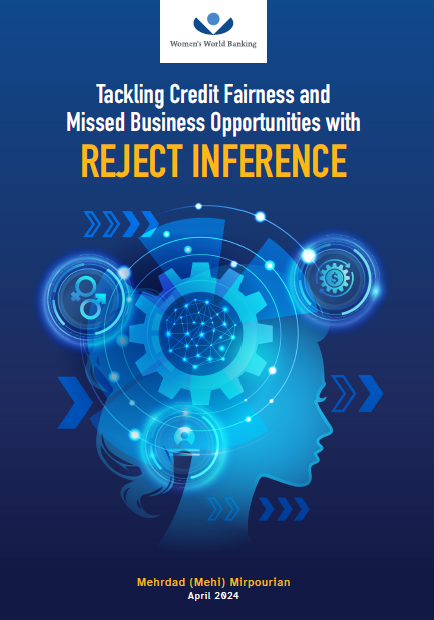

### Introduction: 

People seek credit for a variety of needs, including personal, business, and educational purposes. Financial institutions evaluate credit applications using algorithms, loan officers, or a combination of both. However, these credit evaluation methods are not infallible and are susceptible to errors arising from biases or assessment mistakes. Consequently, many potentially creditworthy applicants are erroneously rejected, resulting in lost opportunities for both the individuals and the financial institutions. Reject inference is a quantitative approach that helps institutions to understand and infer the reasons behind these erroneous rejections and to identify applicants who were mistakenly deemed non-creditworthy. These methods are applied toward the end of the credit evaluation process and offer a non-disruptive solution to financial institutions since the methods do not require major changes to existing credit assessment procedures.

In this notebook, I delve into the application of machine learning in developing an innovative approach to the reject inference problem. The algorithm I am presenting here is based on propensity matching techniques, known for their intuitiveness, relative ease of implementation, and effectiveness in identifying applicants who have been mistakenly rejected. Matching methods, including propensity score matching (PSM), are a class of nonparametric approaches that take observational data and match individuals with similar characteristics but different treatments, to make causal inferences. The intuitive nature of PSM, along with its statistical benefits, renders it a valuable tool for reject inference. PSM creates a statistical comparison group based on a model that predicts the likelihood of receiving the treatment (e.g., a loan in credit applications), using observable characteristics. This probability, known as the propensity score (PS), is then used to match participants (loan recipients) with non-participants (rejected applicants).


###### What You Will See in This Notebook:

First, I create a dummy dataset, which will serve as the foundation for the work in this notebook. I have intentionally kept the dataset simple and compact, yet sufficiently large to facilitate a quick understanding and enable you to learn how the algorithms will be applied to this problem. After creating the dataset, you will learn how to use various algorithms to calculate the propensity score, which forms the basis of our work in finding matched pairs.



***    

<div style="background-color:yellow; color:black; padding:10px;">
<b>Note:</b><br>
The following code blocks, up to the section titled "Estimating Propensity Scores," are used solely to create a dummy dataset and are not part of the core algorithm. This section is optional but included to help you understand how the dataset is constructed and what datasets used for reject inference typically look like.
</div>


## Creating a Dummy Datset

#### Objective: To create a dataset that reflects both data-driven loan approval decisions and human biases, suitable for demonstrating the application of reject inference techniques.
##### Steps:

1. Data Preparation:

Combine features from potential loan applicants into a single dataset. This dataset will include variables like Income, Credit Score, Debt-to-Income Ratio, Age, Length of Employment, etc.

2. Model-Based Decision Making:

Train a logistic regression model on this dataset. The model predicts the probability of an applicant being a good loan candidate (i.e., less likely to default).
Apply the model to each applicant, obtaining a probability score of being a good loan candidate.

3. Threshold-Based Approval:

Set a probability threshold (e.g., 50%). Applicants with scores above this threshold are initially approved, while those below are initially rejected.

4. Introducing Bias:

Simulate loan officer bias by randomly selecting a certain percentage (e.g., 35%) of initially approved loans and changing their status to rejected. This step represents the erroneous rejections due to officer biases.

5. Final Dataset Creation:

Split the dataset into two groups based on the final decision: 'Approved' and 'Rejected'. The 'Approved' dataset includes loans that were either initially approved and not flipped or flipped from rejected to approved. The 'Rejected' dataset includes both the initially rejected and the approved loans that were flipped due to bias.

6. Analysis:

Use reject inference techniques on the 'Rejected' dataset to identify which loans might have been wrongly rejected and could potentially be creditworthy.

Result: This process results in two datasets, one representing loans approved by the model and unaffected (or affected) by bias, and the other representing loans rejected either by the model or due to the loan officer's bias. These datasets provide a realistic foundation for demonstrating reject inference methods.

#### Importing the required libraries. 

In [54]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from pygam import LogisticGAM, s

from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC

from xgboost import XGBClassifier
import xgboost as xgb

import os

This following block of code generates a synthetic dataset to simulate loan application decisions based on financial criteria. It aims to reflect a scenario where approximately 70% of applicants are rejected to mimic realistic loan approval rates.

Key Components:
- `generate_unique_id(index)`: Generates a unique alphanumeric ID for each loan application record.
- `create_combined_dataset()`: Creates a dataset of synthetic loan applicants. Features include Income, Credit_Score, Debt_to_Income_Ratio, Age, Length_of_Employment, and Requested_Loan_Amount. Each applicant is assigned a 'Creditworthiness_Score' based on these features, calculated using pre-defined coefficients that reflect their impact on loan approval chances.
- The approval decision ('Credit_Decision') is made using a threshold set at the 70th percentile of the Creditworthiness_Score, targeting a 70% rejection rate among applicants.

Purpose:
The dataset and subsequent analysis aim to provide a foundation for exploring reject inference problems using propensity score matching.



In [6]:
def generate_unique_id(index):
    """Generate a unique alphanumeric ID for each record."""
    return f"LOAN_{index:05d}"

def create_combined_dataset():
    np.random.seed(0)  # For reproducibility
    
    size = 4744  # Total size of the dataset
    
    # Generating dataset
    df = pd.DataFrame({
        'Income': np.random.uniform(1000, 10000, size),
        'Credit_Score': np.random.uniform(300, 800, size),
        'Debt_to_Income_Ratio': np.random.uniform(0, 1, size),
        'Age': np.random.randint(18, 70, size),
        'Length_of_Employment': np.random.randint(0, 40, size),
        'Requested_Loan_Amount': np.random.uniform(500, 50000, size),
    })
    
    # Assign unique IDs and set as the first column
    df.insert(0, 'Loan_ID', [generate_unique_id(i) for i in range(size)])
    
    # Manually defined coefficients based on financial principles
    coefficients = {
        'Income': 0.0001,  # Positive impact
        'Credit_Score': 0.001,  # Positive impact
        'Debt_to_Income_Ratio': -0.5,  # Negative impact
        'Age': 0.01,  # Slight positive impact
        'Length_of_Employment': 0.05,  # Positive impact
        'Requested_Loan_Amount': -0.0001  # Negative impact, especially if high relative to income
    }
    
    # Calculate a creditworthiness score for each applicant
    df['Creditworthiness_Score'] = (
        df['Income'] * coefficients['Income'] +
        df['Credit_Score'] * coefficients['Credit_Score'] +
        df['Debt_to_Income_Ratio'] * coefficients['Debt_to_Income_Ratio'] +
        df['Age'] * coefficients['Age'] +
        df['Length_of_Employment'] * coefficients['Length_of_Employment'] +
        df['Requested_Loan_Amount'] * coefficients['Requested_Loan_Amount']
    )
    
    # Determine a threshold for loan approval to aim for ~70% rejection rate
    threshold = df['Creditworthiness_Score'].quantile(0.7)  # Adjusting threshold to the 70th percentile
    
    # Use the threshold to make credit decisions
    df['Credit_Decision'] = (df['Creditworthiness_Score'] >= threshold).astype(int)
    
    return df
# Generate the dataset and calculate the approval rate
df_combined = create_combined_dataset()

- Introducing Bias into the Dataset:
To simulate a more complex scenario that reflects real-world challenges in loan approval processes, I introduced bias into the dataset. The objective is to mimic the effect of non-data-driven factors, such as human biases or external pressures, that might influence loan officer decisions. This modification allows us to explore the reject inference problem more deeply, specifically focusing on identifying which rejected applicants might have been affected by such biases.


In [11]:
def introduce_bias_with_final_decision_existing_df(df, flip_rate=0.2):
    """
    For an existing dataset, randomly selects a percentage 
    (specified by flip_rate)of approved applicants 
    (where Credit_Decision = 1) and flips their decision to rejection,
    reflecting this in a new column named Final_Credit_Decision.
    """
    # Initialize the Final_Credit_Decision column with existing Credit_Decision values
    df['Final_Credit_Decision'] = df['Credit_Decision']
    
    # Find indices of applicants with an approved Credit_Decision
    approved_indices = df[df['Credit_Decision'] == 1].index
    
    # Calculate the number of approved decisions to flip
    num_to_flip = int(len(approved_indices) * flip_rate)
    
    # Randomly select indices of approved applicants to flip to rejected
    indices_to_flip = np.random.choice(approved_indices, size=num_to_flip, replace=False)
    
    # Update the Final_Credit_Decision for the selected applicants to indicate rejection
    df.loc[indices_to_flip, 'Final_Credit_Decision'] = 0
    
    return df

df_combined = introduce_bias_with_final_decision_existing_df(df_combined, flip_rate=0.2)

In [12]:
""" Splitting the data into train and test split """
train_df, test_df = train_test_split(df_combined, test_size = 0.2, 
                                     random_state = 42)

***

## Estimating Propensity Scores
The core of this reject inference approach presented in this notebook, is based on the calculation of propensity scores. In this section of the notebook, we will explain how to use various methods to estimate these scores.

#### <span style="color: yellow;">1. Estimating Propensity Scores Using Logistic Regression</span>

##### <span style="color: orange;">Learn by an Example</span>

In [ ]:
# Select features and target for the logistic regression model.
# Features are used in making credit decisions, and the target indicates the credit decision outcome.
features = ['Income', 'Credit_Score', 'Debt_to_Income_Ratio', 'Age', 'Length_of_Employment', 'Requested_Loan_Amount']
target = 'Final_Credit_Decision'

# Prepare the feature matrix (X) and target vector (y) from the main dataset.
X = df_combined[features]
y = df_combined[target]

# Define categorical and numeric columns.
# Update categorical_columns as needed.
categorical_columns = []  # Example: ['Gender', 'Marital_Status']
numeric_columns = [col for col in X.columns if col not in categorical_columns]

# Create a preprocessing pipeline for numeric features using StandardScaler.
# Add transformations for categorical data if necessary.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),  # Scale numeric columns
        # Uncomment the following line if you have categorical features
        # ('cat', OneHotEncoder(), categorical_columns)  # Encode categorical columns
    ])

# Compute class weights to handle imbalanced data.
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

# Set up a logistic regression pipeline with preprocessing and class weight adjustments.
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight=class_weight_dict, random_state=0))
])

# Fit the logistic regression model to the data.
pipeline.fit(X, y)

# Calculate and store propensity scores in the dataframe.
df_combined['LR_Propensity_Score'] = pipeline.predict_proba(X)[:, 1]  # Probability of approval

##### <span style="color: purple;">The Generic Function</span>


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np

def compute_propensity_scores(df, features, target, categorical_columns = None):
    """
    Computes the propensity scores using a logistic regression model based on the provided features and target.

    Parameters:
    df (DataFrame): The dataset containing the features and target.
    features (list): List of column names to be used as features.
    target (str): Column name of the target variable.
    categorical_columns (list, optional): List of column names that are categorical. Defaults to None.

    Returns:
    DataFrame: The input dataframe with an additional column for propensity scores.
    """
    # Prepare the feature matrix (X) and target vector (y)
    X = df[features]
    y = df[target]

    # Determine which columns are numeric
    if categorical_columns is None:
        categorical_columns = []
    numeric_columns = [col for col in features if col not in categorical_columns]

    # Create a preprocessing pipeline for numeric and categorical features
    transformers = [('num', StandardScaler(), numeric_columns)]
    if categorical_columns:
        transformers.append(('cat', OneHotEncoder(), categorical_columns))
    
    preprocessor = ColumnTransformer(transformers = transformers)

    # Compute class weights to handle imbalanced data
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y = y)
    class_weight_dict = dict(enumerate(class_weights))

    # Set up a logistic regression pipeline with preprocessing and class weight adjustments
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(class_weight=class_weight_dict, random_state=0))
    ])

    # Fit the logistic regression model to the data
    pipeline.fit(X, y)

    # Calculate and store propensity scores in the dataframe
    df['LR_Propensity_Score'] = pipeline.predict_proba(X)[:, 1]  # Probability of approval

    return df

# Example usage
df_combined = pd.DataFrame()  # Assuming df_combined is already loaded with your data
features = ['Income', 'Credit_Score', 'Debt_to_Income_Ratio', 'Age', 'Length_of_Employment', 'Requested_Loan_Amount']
target = 'Final_Credit_Decision'
categorical_columns = []  # Specify your categorical columns here if any

# Compute the propensity scores
df_combined = compute_propensity_scores(df_combined, features, target, categorical_columns)

***

#### <span style="color: yellow;">2. Estimating Propensity Scores Using Random Forest</span>

##### <span style="color: orange;">Learn by an Example</span>

In [ ]:
# Define the Random Forest model with specified parameters.
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

# Create a preprocessing and modeling pipeline using a pre-defined preprocessor and the Random Forest classifier.
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),  # Utilize the pre-existing preprocessor for scaling.
    ('classifier', rf_model)        # Incorporate the Random Forest classifier.
])

# Define features and target for modeling.
X = df_combined[features]
y = df_combined['Final_Credit_Decision']  # Define the target variable.

# Train the Random Forest model using the full dataset.
pipeline_rf.fit(X, y)

# Calculate and store propensity scores using the Random Forest model for the entire dataset.
df_combined['RF_Propensity_Score'] = pipeline_rf.predict_proba(X)[:, 1]  # Store propensity scores.

##### <span style="color: purple;">The Generic Function</span>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import pandas as pd

def compute_rf_propensity_scores(df, features, target, preprocessor, n_estimators = 100, random_state = 0):
    """
    Computes the propensity scores using a Random Forest model based on the provided features and target.
    
    Parameters:
    df (DataFrame): The dataset containing the features and target.
    features (list): List of column names to be used as features.
    target (str): Column name of the target variable.
    preprocessor (Transformer): A pre-defined preprocessor configured for the data.
    n_estimators (int): The number of trees in the forest.
    random_state (int): Controls both the randomness of the bootstrapping of the samples used when building trees (if `bootstrap=True`) and the sampling of the features to consider when looking for the best split at each node (if `max_features < n_features`).
    
    Returns:
    DataFrame: The input dataframe with an additional column for Random Forest propensity scores.
    """
    # Define the Random Forest model with specified parameters
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)

    # Create a preprocessing and modeling pipeline with the Random Forest classifier
    pipeline_rf = Pipeline([
        ('preprocessor', preprocessor),  # Integrate the pre-existing preprocessor
        ('classifier', rf_model)         # Utilize the Random Forest classifier
    ])

    # Define feature matrix (X) and target vector (y)
    X = df[features]
    y = df[target]

    # Train the Random Forest model on the full dataset
    pipeline_rf.fit(X, y)

    # Calculate and store propensity scores in the dataframe
    df['RF_Propensity_Score'] = pipeline_rf.predict_proba(X)[:, 1]  # Probability of the positive class

    return df

# Example usage
# Assuming df_combined is your DataFrame and 'preprocessor' is already defined
df_combined = pd.DataFrame()  # Placeholder for your actual DataFrame
features = ['Income', 'Credit_Score', 'Debt_to_Income_Ratio', 'Age', 'Length_of_Employment', 'Requested_Loan_Amount']
target = 'Final_Credit_Decision'
# Define or import your 'preprocessor' before using this function

# Compute the Random Forest propensity scores with specific model parameters
df_combined = compute_rf_propensity_scores(df_combined, features, target, preprocessor, n_estimators=200, random_state=42)

***

#### <span style="color: yellow;">3. Estimating Propensity Scores Using XGBoost</span>

##### <span style="color: orange;">Learn by an Example</span>

In [1]:
# Define the preprocessor if not already defined, targeting numeric features for scaling.
numeric_features = ['Income', 'Credit_Score', 'Debt_to_Income_Ratio', 'Age', 'Length_of_Employment', 'Requested_Loan_Amount']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ])

# Define the XGBoost model with specific parameters to handle label encoding and evaluation metric.
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create a preprocessing and modeling pipeline using XGBoost.
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),  # Apply the defined preprocessing to the data.
    ('classifier', xgb_model)        # Integrate the XGBoost classifier.
])

# Define features (X) and target (y) for modeling.
X = df_combined[numeric_features]  
y = df_combined['Final_Credit_Decision']  # Confirm this is the correct target variable.

# Train the XGBoost model using the full dataset.
pipeline_xgb.fit(X, y)

# Calculate and store the propensity scores using XGBoost for the entire dataset.
df_combined['XGB_Propensity_Score'] = pipeline_xgb.predict_proba(X)[:, 1]  # Store propensity scores for later analysis.

##### <span style="color: purple;">The Generic Function</span>


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import pandas as pd

def compute_xgb_propensity_scores(df, features, target, use_label_encoder=False, eval_metric='logloss'):
    """
    Computes propensity scores using an XGBoost model based on provided features and target.
    
    Parameters:
    df (DataFrame): The dataset containing the features and target.
    features (list): List of column names to be used as features.
    target (str): Column name of the target variable.
    use_label_encoder (bool): Flag to control label encoding by XGBoost.
    eval_metric (str): Evaluation metric for the model training.
    
    Returns:
    DataFrame: The input dataframe with an additional column for XGBoost propensity scores.
    """
    # Define the preprocessor for numeric features using standard scaling
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), features)
        ])

    # Define the XGBoost model with specified parameters
    xgb_model = XGBClassifier(use_label_encoder = use_label_encoder, eval_metric = eval_metric)

    # Create a preprocessing and modeling pipeline incorporating the XGBoost classifier
    pipeline_xgb = Pipeline([
        ('preprocessor', preprocessor),  # Integrate preprocessing step
        ('classifier', xgb_model)        # Use XGBoost as the classifier
    ])

    # Define feature matrix (X) and target vector (y)
    X = df[features]
    y = df[target]

    # Train the XGBoost model on the full dataset
    pipeline_xgb.fit(X, y)

    # Calculate and store the propensity scores in the dataframe
    df['XGB_Propensity_Score'] = pipeline_xgb.predict_proba(X)[:, 1]  # Probability of the positive class

    return df

# Example usage
# Assuming df_combined is your DataFrame
df_combined = pd.DataFrame()  # Placeholder for your actual DataFrame
features = ['Income', 'Credit_Score', 'Debt_to_Income_Ratio', 'Age', 'Length_of_Employment', 'Requested_Loan_Amount']
target = 'Final_Credit_Decision'

# Compute the XGBoost propensity scores with specific model parameters
df_combined = compute_xgb_propensity_scores(df_combined, features, target, use_label_encoder=False, eval_metric='logloss')

***

#### <span style="color: yellow;">4. Estimating Propensity Scores Using Support Vector Machines (SVM)</span>

##### <span style="color: orange;">Learn by an Example</span>

In [16]:
# Define the preprocessor for numeric features if not already established.
numeric_features = ['Income', 'Credit_Score', 'Debt_to_Income_Ratio', 'Age', 'Length_of_Employment', 'Requested_Loan_Amount']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ])

# Define the SVM model with probability estimation enabled for further analysis.
svm_model = SVC(probability=True, random_state=0)

# Create a preprocessing and modeling pipeline incorporating the SVM classifier.
pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),  # Apply scaling preprocessing to numeric features.
    ('classifier', svm_model)        # Integrate the SVM classifier with probability support.
])

# Identify features (X) and the target variable (y) for modeling.
X = df_combined[numeric_features]
y = df_combined['Final_Credit_Decision']  # Confirm that this is the correct target variable.

# Train the SVM model on the entire dataset.
pipeline_svm.fit(X, y)

# Calculate and store the propensity scores using the SVM model for the entire dataset.
df_combined['SVM_Propensity_Score'] = pipeline_svm.predict_proba(X)[:, 1]  # Record propensity scores for evaluation.

##### <span style="color: purple;">The Generic Function</span>


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd

def compute_svm_propensity_scores(df, features, target, random_state = 0, probability = True):
    """
    Computes propensity scores using an SVM model based on provided features and target.
    
    Parameters:
    df (DataFrame): The dataset containing the features and target.
    features (list): List of column names to be used as features.
    target (str): Column name of the target variable.
    random_state (int): Controls the randomness of the estimator.
    probability (bool): Whether to enable probability estimates.
    
    Returns:
    DataFrame: The input dataframe with an additional column for SVM propensity scores.
    """
    # Define the preprocessor for numeric features using standard scaling
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), features)
        ])

    # Define the SVM model with probability estimation enabled
    svm_model = SVC(probability=probability, random_state=random_state)

    # Create a preprocessing and modeling pipeline incorporating the SVM classifier
    pipeline_svm = Pipeline([
        ('preprocessor', preprocessor),  # Apply scaling preprocessing to numeric features
        ('classifier', svm_model)        # Integrate the SVM classifier with probability support
    ])

    # Define feature matrix (X) and target vector (y)
    X = df[features]
    y = df[target]

    # Train the SVM model on the full dataset
    pipeline_svm.fit(X, y)

    # Calculate and store the propensity scores in the dataframe
    df['SVM_Propensity_Score'] = pipeline_svm.predict_proba(X)[:, 1]  # Record propensity scores for evaluation

    return df

# Example usage
# Assuming df_combined is your DataFrame
df_combined = pd.DataFrame()  # Placeholder for your actual DataFrame
features = ['Income', 'Credit_Score', 'Debt_to_Income_Ratio', 'Age', 'Length_of_Employment', 'Requested_Loan_Amount']
target = 'Final_Credit_Decision'

# Compute the SVM propensity scores with specified model parameters
df_combined = compute_svm_propensity_scores(df_combined, features, target, random_state = 0, probability = True)

***

#### Key Considerations for SVM:

* Parameter Tuning: The performance of an SVM is highly dependent on parameters such as the kernel type, the regularization parameter (C), and the kernel coefficient (gamma). Proper tuning is essential for optimal performance.

* Computational Cost: SVMs can be computationally intensive, particularly with large datasets. This could be a limiting factor depending on the computational resources available.

* Interpretability: Compared to more straightforward models like logistic regression, SVMs offer less interpretability. This could be a significant consideration depending on the application's requirements.

* Model Suitability and Validation: It is crucial to assess whether the SVM model is suitable for your specific dataset and objectives. The calibration step for probability estimation is critical and requires thorough validation.

* Code Considerations: The provided code snippet includes the basic setup for using an SVM with probability estimates (SVC(probability=True)). However, it lacks steps for explicitly validating the calibration.

* Validating Calibration: To adequately validate the calibration, you would typically use a calibration curve to assess how well the predicted probabilities align with the actual outcomes. This step is crucial for propensity score estimation as the accuracy of these scores directly impacts the effectiveness of subsequent analyses.


#### <span style="color: yellow;">5. Estimating Propensity Scores Using Multi Layer Perceptron (MLP)</span>

##### <span style="color: orange;">Learn by an Example</span>

In [2]:
# Define preprocessor for numeric features using standard scaling
numeric_features = ['Income', 'Credit_Score', 'Debt_to_Income_Ratio', 'Age', 'Length_of_Employment', 'Requested_Loan_Amount']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)  # Apply standard scaling to numeric columns
    ])

# Define the Neural Network (MLP) model with specific configurations
nn_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # Configuration: two hidden layers of 100 and 50 nodes
    activation='relu',  # Activation function: ReLU
    solver='adam',  # Optimization algorithm: Adam
    alpha=0.0001,  # L2 regularization strength
    random_state=0,  # Seed for randomness
    max_iter=200  # Maximum iterations for the solver
)

# Create a pipeline integrating preprocessing and the neural network classifier
pipeline_nn = Pipeline([
    ('preprocessor', preprocessor),  # Integrate preprocessing steps
    ('classifier', nn_model)  # Use the defined neural network as the classifier
])

# Define feature matrix (X) and target vector (y)
X = df_combined[numeric_features]
y = df_combined['Final_Credit_Decision']  # Target variable for model training

# Train the Neural Network model using the full dataset
pipeline_nn.fit(X, y)

# Calculate and store propensity scores using the Neural Network across the dataset
df_combined['NN_Propensity_Score'] = pipeline_nn.predict_proba(X)[:, 1]  # Store the probability of the positive class

##### <span style="color: purple;">The Generic Function</span>


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import pandas as pd

def compute_nn_propensity_scores(df, features, target, hidden_layer_sizes=(100, 50), activation = 'relu', solver = 'adam', alpha = 0.0001, random_state = 0, max_iter = 200):
    """
    Computes propensity scores using a Neural Network (MLP) model based on provided features and target.
    
    Parameters:
    df (DataFrame): The dataset containing the features and target.
    features (list): List of column names to be used as features.
    target (str): Column name of the target variable.
    hidden_layer_sizes (tuple): Number of neurons in each hidden layer.
    activation (str): Activation function for the hidden layers.
    solver (str): The solver for weight optimization.
    alpha (float): L2 penalty (regularization term) parameter.
    random_state (int): Determines random number generation for weights and bias initialization.
    max_iter (int): Maximum number of iterations.
    
    Returns:
    DataFrame: The input dataframe with an additional column for Neural Network propensity scores.
    """
    # Define the preprocessor for numeric features using standard scaling
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), features)  # Apply standard scaling to numeric columns
        ])

    # Define the Neural Network model with specified configurations
    nn_model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        random_state=random_state,
        max_iter=max_iter
    )

    # Create a pipeline integrating preprocessing and the neural network classifier
    pipeline_nn = Pipeline([
        ('preprocessor', preprocessor),  # Integrate preprocessing steps
        ('classifier', nn_model)  # Use the defined neural network as the classifier
    ])

    # Define feature matrix (X) and target vector (y)
    X = df[features]
    y = df[target]

    # Train the Neural Network model on the full dataset
    pipeline_nn.fit(X, y)

    # Calculate and store the propensity scores in the dataframe
    df['NN_Propensity_Score'] = pipeline_nn.predict_proba(X)[:, 1]  # Record propensity scores for evaluation

    return df

# Example usage
# Assuming df_combined is your DataFrame
df_combined = pd.DataFrame()  # Placeholder for your actual DataFrame
features = ['Income', 'Credit_Score', 'Debt_to_Income_Ratio', 'Age', 'Length_of_Employment', 'Requested_Loan_Amount']
target = 'Final_Credit_Decision'

# Compute the Neural Network propensity scores with specified model parameters
df_combined = compute_nn_propensity_scores(df_combined, features, target)

***

#### <span style="color: yellow;">6. Estimating Propensity Scores Using Generalized Additive Models (GAMs)</span>

##### <span style="color: orange;">Learn by an Example</span>

In [26]:
# Define the feature set for modeling
features = ['Income', 'Credit_Score', 'Debt_to_Income_Ratio', 'Age', 'Length_of_Employment', 'Requested_Loan_Amount']
X = df_combined[features].values  # Extract feature values from the dataset
y = df_combined['Final_Credit_Decision'].values  # Extract target variable values from the dataset

# Define the Generalized Additive Model (GAM) with spline terms for each feature to model non-linear relationships
gam = LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5))

# Fit the GAM to the dataset
gam.fit(X, y)

# Calculate and store propensity scores using the fitted GAM model
df_combined['GAM_Propensity_Score'] = gam.predict_proba(X)  # Store the predicted probabilities as propensity scores

##### <span style="color: purple;">The Generic Function</span>


In [ ]:
from pygam import LogisticGAM, s
import pandas as pd

def compute_gam_propensity_scores(df, features, target):
    """
    Computes propensity scores using a Generalized Additive Model (GAM) based on provided features and target.
    
    Parameters:
    df (DataFrame): The dataset containing the features and target.
    features (list): List of column names to be used as features.
    target (str): Column name of the target variable.
    
    Returns:
    DataFrame: The input dataframe with an additional column for GAM propensity scores.
    """
    # Define the feature matrix (X) and target vector (y)
    X = df[features].values  # Extract feature values from the dataset
    y = df[target].values  # Extract target variable values from the dataset

    # Define the Generalized Additive Model (GAM) with spline terms for each feature to model non-linear relationships
    # Dynamic generation of spline terms based on the number of features
    gam = LogisticGAM(sum(s(i) for i in range(len(features))))

    # Fit the GAM to the dataset
    gam.fit(X, y)

    # Calculate and store the propensity scores in the dataframe
    df['GAM_Propensity_Score'] = gam.predict_proba(X)  # Store the predicted probabilities as propensity scores

    return df

# Example usage
# Assuming df_combined is your DataFrame
df_combined = pd.DataFrame()  # Placeholder for your actual DataFrame
features = ['Income', 'Credit_Score', 'Debt_to_Income_Ratio', 'Age', 'Length_of_Employment', 'Requested_Loan_Amount']
target = 'Final_Credit_Decision'

# Compute the GAM propensity scores
df_combined = compute_gam_propensity_scores(df_combined, features, target)

***

#### <span style="color: yellow;">7. Estimating Propensity Scores Using K-Nearest Neighbors (KNN)</span>

##### <span style="color: orange;">Learn by an Example</span>

In [27]:
# Define the list of features used in the analysis
features = ['Income', 'Credit_Score', 'Debt_to_Income_Ratio', 'Age', 'Length_of_Employment', 'Requested_Loan_Amount']
X = df_combined[features]  # Extract the feature data from the dataframe
y = df_combined['Final_Credit_Decision']  # Extract the target variable data

# Define the preprocessor for scaling numeric features
# Assuming all selected features are numeric based on previous discussions
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features)  # Apply standard scaling to numeric columns
    ])

# Define the K-Nearest Neighbors (KNN) model specifying the number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)

# Create a preprocessing and modeling pipeline incorporating the KNN classifier
pipeline_knn = Pipeline([
    ('preprocessor', preprocessor),  # Integrate preprocessing step
    ('classifier', knn_model)        # Use KNN as the classifier
])

# Train the KNN model using the full dataset
pipeline_knn.fit(X, y)

# Calculate and store propensity scores using the KNN model for the entire dataset
df_combined['KNN_Propensity_Score'] = pipeline_knn.predict_proba(X)[:, 1]  # Save the probability of the positive class

##### <span style="color: purple;">The Generic Function</span>


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

def compute_knn_propensity_scores(df, features, target, n_neighbors = 5):
    """
    Computes propensity scores using a K-Nearest Neighbors (KNN) model based on provided features and target.
    
    Parameters:
    df (DataFrame): The dataset containing the features and target.
    features (list): List of column names to be used as features.
    target (str): Column name of the target variable.
    n_neighbors (int): Number of neighbors to use for KNN.
    
    Returns:
    DataFrame: The input dataframe with an additional column for KNN propensity scores.
    """
    # Define the preprocessor for scaling numeric features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), features)  # Apply standard scaling to numeric columns
        ])

    # Define the K-Nearest Neighbors (KNN) model with specified parameters
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Create a preprocessing and modeling pipeline incorporating the KNN classifier
    pipeline_knn = Pipeline([
        ('preprocessor', preprocessor),  # Integrate preprocessing step
        ('classifier', knn_model)        # Use KNN as the classifier
    ])

    # Define feature matrix (X) and target vector (y)
    X = df[features]
    y = df[target]

    # Train the KNN model on the full dataset
    pipeline_knn.fit(X, y)

    # Calculate and store the propensity scores in the dataframe
    df['KNN_Propensity_Score'] = pipeline_knn.predict_proba(X)[:, 1]  # Record propensity scores for evaluation

    return df

# Example usage
# Assuming df_combined is your DataFrame
df_combined = pd.DataFrame()  # Placeholder for your actual DataFrame
features = ['Income', 'Credit_Score', 'Debt_to_Income_Ratio', 'Age', 'Length_of_Employment', 'Requested_Loan_Amount']
target = 'Final_Credit_Decision'

# Compute the KNN propensity scores with specified model parameters
df_combined = compute_knn_propensity_scores(df_combined, features, target, n_neighbors = 5)

***

## Performing Balance Checks on Propensity Scores

After estimating propensity scores for our dataset, it's crucial to ensure that these scores effectively balance the covariates between our treated (loan approved) and control (loan rejected) groups. This step is fundamental in propensity score matching and helps validate the reliability of our propensity scores.

- What Are Balance Checks?
Balance checks involve comparing the distribution of covariates between treated and control groups after matching based on propensity scores. The goal is to ascertain that our matching process has resulted in groups that are comparable across key characteristics, minimizing selection bias.

- How Do We Conduct Balance Checks?
We utilize the Standardized Mean Difference (SMD) as a metric to assess the balance of each covariate. The SMD compares the difference in means between the treated and control groups, standardized by the pooled standard deviation of the two groups.

- Interpreting SMDs:

An SMD < 0.1 indicates a negligible imbalance, suggesting our matching process has been effective.

An SMD between 0.1 and 0.2 points to a moderate imbalance, requiring closer inspection.

An SMD > 0.2 signals a significant imbalance, indicating that our propensity score model may need adjustment.


Our objective is to achieve SMDs below 0.1 for all covariates, ensuring that our treated and control groups are well-balanced and that subsequent analyses on the effect of loan approval are robust and reliable.

#### Practical Guideline

Assessing the Quality of Matches Through Balance Testing
- Synthetic Data Analysis
In this notebook, the goal is to use synthetic dataset to simulate the loan approval process typically encountered in financial institutions, introducing an element of human bias to replicate real-world decision-making inaccuracies. This process results in three distinct groups within our dataset:

Group 1 - Rejected by the Model: These are applicants that the logistic regression model initially rejects based on their likelihood of default. This group represents decisions made purely on algorithmic assessments without human intervention.

Group 2 - Biased Rejections: Applicants initially approved by the logistic model but whose approval status is manually inverted to simulate bias. This alteration mimics scenarios where potentially creditworthy individuals are erroneously rejected due to subjective biases or oversight.

Group 3 - Approved and Unflipped: Constitutes applicants who were approved by the logistic model, and their approval status remained unchanged. This group represents the model's unbiased decisions deemed creditworthy without subsequent manual intervention.

Given this study's objective to explore the reject inference problem—specifically, to identify applicants who were mistakenly deemed non-creditworthy due to bias—the comparison between Group 2 (Biased Rejections) and Group 3 (Approved and Unflipped) is paramount. This comparison is instrumental in validating our synthetic bias injection approach and establishing a foundation for applying reject inference techniques. By conducting balance tests between these groups, we assess the effectiveness of our methodology in simulating realistic biased decision scenarios and ensuring that the flagged rejected cases (Group 2) are indeed comparable to approved cases (Group 3) in terms of observable characteristics.

- Real-World Application
In real-world scenarios, unlike the controlled synthetic environment, we do not have the luxury of knowing a priori which rejections are biased. To navigate this challenge, I adopt a strategy that leverages the calculated propensity scores using various machine learning algorithms. This approach involves:

Propensity Score Estimation: Calculating propensity scores for all applicants using multiple algorithms to estimate each applicant's likelihood of being approved based on observable characteristics.

Algorithm Selection: Assessing the performance of each algorithm on a test set comprising 20% of the approved applicants. This subset serves as a proxy for identifying the algorithm that most accurately predicts approval status, under the assumption that rejected applicants, who could have been approved, share similar characteristics with those in the test set.

Flagging Potentially Biased Rejections: Utilizing the selected algorithm, we flag rejected applicants that exhibit similar characteristics (and thus propensity scores) to those of approved applicants. These flagged cases are hypothesized to represent individuals potentially rejected due to bias or mistakes.

Balance Testing Between Flagged Rejections and Approved Cases: We then conduct balance tests, comparing the distribution of propensity scores and other covariates between the flagged rejected applicants and approved applicants. This step is crucial for validating our hypothesis that the flagged rejections share similar characteristics with approved cases, underscoring the potential for these individuals to have been erroneously rejected.

In [29]:
def calculate_smd(df, column, treatment_col = 'Final_Credit_Decision'):
    """Calculate Standardized Mean Difference (SMD) for a column between treatment groups."""
    treatment = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]
    mean_treatment = treatment[column].mean()
    mean_control = control[column].mean()
    pooled_std = np.sqrt((treatment[column].std() ** 2 + control[column].std() ** 2) / 2)
    smd = (mean_treatment - mean_control) / pooled_std
    return smd

# Calculating SMDs for each covariate
covariates = ['Income', 'Credit_Score', 'Debt_to_Income_Ratio', 'Age', 'Length_of_Employment', 'Requested_Loan_Amount']
smds_before = {cov: calculate_smd(df_combined, cov) for cov in covariates}

# Check if covariates are balanced
balance_check_passed = all(smd < 0.1 for smd in smds_before.values())

##### <span style="color: orange;">Learn by an Example</span>

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the best model's propensity scores are stored in 'Best_Model_Propensity_Score'
# and your target variable is 'Final_Credit_Decision'

# Visualizing the overlap of propensity scores for Approved and Rejected cases
sns.histplot(df_combined[df_combined['Final_Credit_Decision'] == 1]['Best_Model_Propensity_Score'], 
             color='blue', stat='density', bins=20, label='Approved')
sns.histplot(df_combined[df_combined['Final_Credit_Decision'] == 0]['Best_Model_Propensity_Score'], 
             color='red', stat='density', bins=20, label='Rejected')

plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Overlap of Propensity Scores Between Approved and Rejected Cases')
plt.legend()
plt.show()

##### <span style="color: purple;">Generic Function</span>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_propensity_scores(df, propensity_score_column, target_variable, title='Overlap of Propensity Scores'):
    """
    Plots the density distribution of propensity scores for different classes in the target variable.

    Parameters:
    df (DataFrame): The dataframe containing the propensity scores and target variable.
    propensity_score_column (str): The column name where the propensity scores are stored.
    target_variable (str): The column name of the target variable.
    title (str, optional): Title of the plot. Defaults to 'Overlap of Propensity Scores'.
    """
    # Set up the seaborn style for better aesthetics
    sns.set(style="whitegrid")
    
    # Plotting propensity scores for the approved cases
    sns.histplot(df[df[target_variable] == 1][propensity_score_column], 
                 color='blue', stat='density', bins=20, label='Approved',
                 kde=True, element="step", fill=False)

    # Plotting propensity scores for the rejected cases
    sns.histplot(df[df[target_variable] == 0][propensity_score_column], 
                 color='red', stat='density', bins=20, label='Rejected',
                 kde=True, element="step", fill=False)

    # Setting up plot labels and title
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend(title='Status')
    plt.show()

# Example usage
# Assuming df_combined is your DataFrame and 'Best_Model_Propensity_Score' is the column with the scores
plot_propensity_scores(df_combined, 'Best_Model_Propensity_Score', 'Final_Credit_Decision')

***

##### A few comments on how to interpret  the overlap test

- Overlap Region: Identifying an overlap region where the propensity scores of both approved and rejected applicants are represented is key to ensuring that matching can occur on a common ground of comparable scores. This indicates that there are individuals in both groups who, based on the model, have similar likelihoods of approval, making them suitable candidates for matching. Your identification of this overlap supports the feasibility of further analysis using propensity score matching.

- Skewed Distributions: The skewness described in both the approved and rejected groups' distributions is indicative of the model’s general differentiation ability between likely approvals and rejections.

- Approved Group (Left-Skewed): The skew towards higher propensity scores among the approved cases is expected, as these are individuals the model finds likely to be approved. The presence of a tail towards lower scores highlights cases where the model is less certain but still resulted in approval—potentially interesting cases for further examination.

- Rejected Group (Right-Skewed): The skew towards lower propensity scores for rejections aligns with expectations. The tail extending into higher scores is particularly significant, as it represents applicants who, despite being modeled as comparably creditworthy to those approved, were rejected. These are critical cases for reject inference, likely indicating the presence of bias or other factors not captured by the model.

***

# Finding Pair Matches Between Approved and Rejected Applicants.

#### Methodology for Caliper Optimization in Propensity Score Matching
In propensity score matching, the precision of matching is pivotal. 
A critical component in this process is the optimization of the matching threshold, commonly referred to as the "caliper". The caliper defines the maximal allowable distance between matched propensity scores, ensuring that only applicants with sufficiently similar scores are paired. The challenge lies in determining an optimal caliper size: too broad, and it may include poorly matched pairs; too narrow, and valuable matches may be excluded, reducing the analysis's statistical power.

To navigate this challenge, I propose utilizing the Standardized Mean Difference (SMD) as a methodological cornerstone for caliper optimization. SMD offers a quantifiable and efficient means to assess the balance between treated and control groups, or in our context, between approved and potentially erroneously rejected applicants. 

In [45]:
def match_applicants_within_caliper(df, credit_decision_column='Credit_Decision', propensity_score_column='Propensity_Score', 
                                    id_column='Loan_ID', max_matches=15, caliper_multiplier=0.2, additional_data_columns=None):
    """
    Matches applicants based on a caliper of propensity scores within a specified radius.

    Parameters:
    df (DataFrame): The dataset containing the applicants.
    credit_decision_column (str): Column name indicating the credit decision (1 for approved, 0 for rejected).
    propensity_score_column (str): Column name for the propensity score.
    id_column (str): Column name for the unique identifier of each applicant.
    max_matches (int): Maximum number of matches to return per rejected applicant.
    caliper_multiplier (float): Multiplier to define the caliper based on the standard deviation of the propensity scores.
    additional_data_columns (list of str): List of additional column names to include in the output for matched records.

    Returns:
    DataFrame: A DataFrame containing the match details for each rejected applicant.
    """
    # Separating the dataset by approval status
    df_approved = df[df[credit_decision_column] == 1]
    df_rejected = df[df[credit_decision_column] == 0]

    # Calculating the caliper based on the standard deviation of propensity scores
    caliper = caliper_multiplier * np.std(df[propensity_score_column])

    # Setting up nearest neighbors search within the caliper
    nn = NearestNeighbors(radius=caliper)
    nn.fit(df_approved[[propensity_score_column]])  # Fit on approved

    match_data = []
    
    for index, rejected_applicant in df_rejected.iterrows():
        # Getting the propensity score and finding neighbors within caliper
        propensity_score = np.array([rejected_applicant[propensity_score_column]]).reshape(-1, 1)
        distances, indices = nn.radius_neighbors(propensity_score, return_distance=True)
        distances, indices = distances[0], indices[0]

        # Limiting matches if necessary
        limited_indices = indices[:max_matches]
        limited_distances = distances[:max_matches]

        # Preparing match details for each rejected applicant
        match_details = {'Rejected_' + id_column: rejected_applicant[id_column], 'Matches_Found': len(limited_indices)}
        for i, (idx, dist) in enumerate(zip(limited_indices, limited_distances), start=1):
            approved_applicant = df_approved.iloc[idx]
            match_details[f'Match_{i}_' + id_column] = approved_applicant[id_column]
            match_details[f'Match_{i}_Distance'] = dist
            if additional_data_columns:
                for col in additional_data_columns:
                    match_details[f'Match_{i}_{col}'] = approved_applicant[col]

        match_data.append(match_details)

    df_matches = pd.DataFrame(match_data)
    
    return df_matches

# Example usage
df_combined = pd.DataFrame()  # Placeholder for actual DataFrame load
additional_columns = ['Income', 'Credit_Score']  # Example additional data columns
df_matches = match_applicants_within_caliper(df_combined, 'Credit_Decision', 'Propensity_Score', 'Loan_ID', max_matches=5, caliper_multiplier=0.25, additional_data_columns=additional_columns)

***

##### References:
    
* Link to document providing a detailed introduction to Reject Inference and an explanation of the method:

https://www.womensworldbanking.org/wp-content/uploads/2024/05/WWB-Reject-Inference-Report.pdf




* Link to the online course: 

https://www.womensworldbanking.org/course-credit-evaluation-and-fair-lending-for-women/


***